In [1]:
import numpy as np

class Graph:
    def __init__(self, graph=None):
        if graph is None:
            graph = {}
        self.graph = graph

    # dict initializer
    @classmethod
    def from_dict(cls, graph):
        return cls(graph)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if (vertices is None) or (len(vertices) != len(matrix)):
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    # two private methods matrix <-> dictionaries
    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dict form.
        """
        res_dict = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            res_dict[v] = neighbours
        return res_dict

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in dict form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def vertices(self) -> list:
        """
        Returns list of vertices of the graph.
        """
        return [*self.graph.keys()]

    def matrix(self) -> np.array:
        """
        Returns the adjacency matrix of the graph.
        """
        return self._dict_to_matrix(self.graph)

    # redefinition of print for objects of class Graph
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}"
            res += "\n"
        return res

    # The following is for free thanks to the above
    def to_neighbourlist(self, filename: str):
        """
        Saves a graphs to a text file as a neighbour dict.\n
        Filename is a file path.
        """
        file = open(filename, "w")  # open textfile for writing
        file.write(str(self))
        file.close()

    # Modyfying graphs
    def add_vertex(self, vertex):
        """
        Adds a new vertex to the graph.
        """
        if vertex not in self.graph:
            self.graph[vertex] = []

    def del_vertex(self, vertex):
        """
        Removes a vertex from the graph.
        """
        if vertex in self.graph:
            self.graph.pop(vertex)
            for u in self.graph:
                if vertex in self.graph[u]:
                    self.graph[u].remove(vertex)

    def add_arc(self, arc):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        u, v = arc
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)

    def add_edge(self, edge: list):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        if u == v:
            raise ValueError("Loops are not allowed!")
        self.add_vertex(u)
        self.add_vertex(v)
        if v not in self.graph[u]:
            self.graph[u].append(v)
        if u not in self.graph[v]:
            self.graph[v].append(u)

    # reading from a file
    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Read the graph from file, that in each line contains either
        the description of a vertex (one word) or
        the description of an edge/arc (at least 2 words).
        The resulting graph is returned as a neighbourhood list.
        Variable "filename" contains the whole path to the file.
        """
        graph = Graph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) >= 2:             # at least two words, first two are the edge description
            if directed:
              graph.add_arc([words[0], words[1]])
            else:
              graph.add_edge([words[0], words[1]])
        file.close()
        return graph

    @staticmethod
    def random_graph(n: int, p: float):
        """
        Creates a random graph in G(n, p) model.
        """
        rand_graph = Graph()
        for i in range(1, n + 1):
            rand_graph.add_vertex(i)
            for j in range(1, i):
                if random() < p:
                    rand_graph.add_edge([i, j])
        return rand_graph

    @staticmethod
    def cycle(n: int):
        """
        Creates a cycle C_n on n vertices
        """
        cycle = Graph()
        for i in range(n-1):
          cycle.add_edge([i+1, i+2])
        cycle.add_edge([1, n])
        return cycle

    def draw(self):
      """
      Draws the graph using networkx.
      """
      G = nx.Graph()
      for u in self.graph:
        for v in self.graph[u]:
          G.add_edge(u, v)
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      plt.show()

    def Prufer(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.graph)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.graph) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph()
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
            if not x in clist:    # x - least leaf
              break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree

    def connected_components(self):
      """
      Szuka spójnych skłądowych w (nieskierowanym) grafie.
      Zwraca listę zbiorów wierzchołków.
      Uwaga: zerowy element listy zawiera wszystkie wierzchołki grafu
      """
      def DFS(u):
        """
        Przechodzenie w głąb - metoda wewnętrzna
        """
        for w in self.graph[u]:
          if w not in VT[0]:    # w jeszcze nieodwiedzony
            VT[0].add(w)        # już odwiedzony
            VT[-1].add(w)       # w ostatniej (aktualnej) spójnej składowej
            DFS(w)
      """
      VT - lista zbiorów wierzchołków (drzew DFS).
      VT[0] - docelowo lista wszystkich wierzchołków w grafie.
      """
      VT = [set([])]
      for v in self.graph:
        if not v in VT[0]:  # v - nieodwiedzony
          VT[0].add(v)      # już odwiedzony
          VT.append(set([v])) # zalążek nowej spójnej składowej
          DFS(v)
      return VT

    def connected_components_graphs(self):
      """
      Zwraca listę spójnych składowych (jako grafów).
      """
      components = self.connected_components()  # lista zbiorów wierzchołków
      component_graphs = []                     # zalążek listy grafów
      for component in components[1:]:
        subgraph = Graph()
        for vertex in component:
          subgraph.graph[vertex] = self.graph[vertex].copy()
        component_graphs.append(subgraph)
      return component_graphs

    def distance(self, v):
      """
      Oblicza odległości z wierzhołka v do każdego osiąglanego wierzchołka w grafie.
      Używa BFS. Wynik podany jako słownik (indeksowany etykietami wierzchołków).
      """
      dist = {v: 0}   # zalążek słownika
      queue = [v]
      while len(queue) > 0:
        u = queue.pop(0)
        for w in self.graph[u]:
          if not w in dist:
            dist[w] = dist[u] + 1
            queue.append(w)
      return dist
from queue import PriorityQueue

class WeigthtedGraph(Graph):
    def __init__(self, graph=None, weights=None):
        if weights is None:
            weights = {}
        self.weights = weights
        super().__init__(graph)

    # dict initializer
    @classmethod
    def from_dict(cls, graph, weights):
        return cls(graph, weights)

    # przedefiniowanie wypisywania grafów
    def __str__(self):
        res = ""
        for v in self.graph:
            res += f"{v}:"
            for u in self.graph[v]:
                res += f" {u}({self.weights[(v, u)]})"
            res += "\n"
        return res

    def add_arc(self, arc, weight = 1):
        """
        Given pair of vertices (arc variable) add an arc to the graph
        We consider simple, directed graphs.
        """
        super().add_arc(arc)
        self.weights[arc] = weight

    def add_edge(self, edge, weight = 1):
        """
        Given pair of vertices (edge variable) add an edge to existing graph.
        We consider simple, undirected graphs, as symmetric digraphs without loops.
        """
        u, v = edge
        super().add_edge(edge)
        self.weights[edge] = weight
        self.weights[(v, u)] = weight

    @staticmethod
    def from_edges(filename: str, directed = 0):
        """
        Wczytujemy graf z pliku
        """
        graph = WeigthtedGraph()
        file = open(filename, "r")          # open the file to read
        for line in file:                   # for each line of the file
          words = line.strip().split()      # splits the line into words
          if len(words) == 1:               # one word - vertex description
            graph.add_vertex(words[0])
          elif len(words) == 2:             # two words, the edge description
            if directed:
              graph.add_arc((words[0], words[1]))
            else:
              graph.add_edge((words[0], words[1]))
          elif len(words) >= 3:             # at least three words, first three are the weighted edge description
            if directed:
              graph.add_arc((words[0], words[1]), int(words[2]))
            else:
              graph.add_edge((words[0], words[1]), int(words[2]))
        file.close()
        return graph

    def draw(self):
      """
      Rysowanie grafu ważonego.
      """
      G = nx.Graph()
      for u in self.graph:
        for v in self.graph[u]:
          G.add_edge(u, v, weight=self.weights[(u, v)])
      pos = nx.spring_layout(G)
      nx.draw(G, pos, with_labels=True)
      labels = nx.get_edge_attributes(G, 'weight')
      nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
      plt.show()


    def min_spanning_tree(self):
      """
      Oblicza drzewo rozpinające wg algorytmu Jarnika-Prima.
      """
      for v in self.graph:
        break
      wtree = WeigthtedGraph({v:[]}, {})
      total = 0   # całkowita waga
      q = PriorityQueue()
      for u in self.graph[v]:
        q.put((self.weights[(v, u)], v, u))
      while not q.empty():
        w, v, u = q.get()
        if not u in wtree.graph:
          wtree.add_edge((v, u), w)
          total += w
          for x in self.graph[u]:
            if not x in wtree.graph:
              q.put((self.weights[(u, x)], u, x))
      if len(wtree.graph) != len(self.graph):
        print("Graf jest niespójny. Zwrócopne drzewo dla jednej spójnej składowej.")
      return wtree, total


    def Dijkstra(self, s):
      """
      Algorytm Dijkstry. Wyznacza najkrótsze ścieżki z wierzchołka s
      """
      # Init
      dist = {}
      pred = {}
      for v in self.graph:
        dist[v] = float("inf")
        pred[v] = None
      dist[s] = 0
      q = PriorityQueue()
      q.put((dist[s], s))
      while not q.empty():
        d, u = q.get()
        if dist[u] >= d:
          for v in self.graph[u]:
            if dist[v] > dist[u] + self.weights[(u, v)]:
              dist[v] = dist[u] + self.weights[(u, v)]
              pred[v] = u
              q.put((dist[v], v))
      return dist, pred


    def network_flow(self):
      """
      Zwraca sieć przepływową zrobioną ze zwykłego grafu skierowanego, ważonego.
      Dodaje łuki wsteczne z przepustowością 0.
      """
      network = WeigthtedGraph()
      for u in self.graph:
        for v in self.graph[u]:
          network.add_edge((u, v), 0)
      for u in self.graph:
        for v in self.graph[u]:
          network.weights[(u,v)] = self.weights[(u,v)]
      return network


    def maxflow_EK(self, s, t):
      """
      Algorytm Edmondsa-Karpa znajduje maksymalny przepływ z wierzchołka s do t.
      """
      network = self.network_flow()
      n = len(network.graph)
      flow = {xx: 0 for xx in network.weights}
      # wyliczamy ścieżki powiększające przez BFS
      while True:
        pred = {s: None}  # słownik poprzedników
        cap = {s: float("inf")}  # słownik do przepustowości ścieżki
        queue = [s]
        while len(queue) > 0:
          u = queue.pop(0)
          for v in network.graph[u]:
            if (not v in pred) and network.weights[(u, v)] - flow[(u, v)] > 0:
              pred[v] = u
              cap[v] = min(cap[u], network.weights[(u, v)] - flow[(u, v)])
              if v == t:
                break
              else:
                queue.append(v)
          if v == t:
            break
        if not t in pred:     # koniec - nie ma s->t ścieżki
          break
        else:
          # przetwarzamy ścieżkę powiększającą
          v = t
          while v != s:
            u = pred[v]
            flow[(u, v)] += cap[t]
            flow[(v, u)] -= cap[t]
            v = u
      return flow



# Algorytm węgierski – wprowadzenie

**Algorytm węgierski** (znany również jako **algorytm Kuhna–Munkresa**) służy do rozwiązywania problemu przyporządkowania (*assignment problem*). Naszym celem jest przypisanie elementów z jednego zbioru (np. pracowników) do elementów drugiego zbioru (np. zadań) w taki sposób, aby **łączne koszty przypisania były minimalne**.

---

## Problem

Dany jest kwadratowy kosztorys (macierz kosztów) `matrix[i][j]`, gdzie:

- `i` oznacza pracownika
- `j` oznacza zadanie
- `matrix[i][j]` to koszt przypisania pracownika `i` do zadania `j`

**Cel**: przypisać każdego pracownika do dokładnie jednego zadania, minimalizując sumę kosztów.

---

## Etapy algorytmu na przykładzie


|     | Zadanie 0 | Zadanie 1 | Zadanie 2 |
|-----|-----------|-----------|-----------|
| **Pracownik 0** |     30     |     25    |     10    |
| **Pracownik 1** |     15     |     10    |     20    |
| **Pracownik 2** |     25    |     20    |     15     |


1. **Redukcja wierszy i kolumn**  
   - W każdym wierszu odejmujemy najmniejszy element od wszystkich elementów tego wiersza  


      |     | Zadanie 0 | Zadanie 1 | Zadanie 2 |
      |-----|-----------|-----------|-----------|
      | **Pracownik 0** |     20     |     15    |     0    |
      | **Pracownik 1** |     5     |     0    |     10    |
      | **Pracownik 2** |     10    |     5    |     0     |

   - Następnie robimy to samo dla kolumn

      |     | Zadanie 0 | Zadanie 1 | Zadanie 2 |
      |-----|-----------|-----------|-----------|
      | **Pracownik 0** |     15     |     15    |     0    |
      | **Pracownik 1** |     0     |     0    |     10    |
      | **Pracownik 2** |     5    |     5    |     0     |



2. **Pokrycie wszystkich zer minimalną liczbą linii**  
   - Zakreśl minimalną liczbę wierszy i kolumn tak, aby zakryć wszystkie zera

      |     | Zadanie 0 | Zadanie 1 |~~ Zadanie 2 ~~| Zakreślone kolumny |
      |-----|-----------|-----------|-----------|--------------------|
      | **Pracownik 0** |     15     |     15    |   ~~0~~  | |
      | ~~**Pracownik 1**~~ |   ~~0~~   |   ~~0~~ | ~~10~~   | X |
      | **Pracownik 2** |     5    |     5    |   ~~0~~   | |
      | Zakreślone wiersze | | | X|

      Łącznie zakreśleń: 2
3. **Sprawdzenie warunku końca**  
   - Jeśli liczba linii = liczba wierszy (lub kolumn) → przejdź do przypisania
   - W przeciwnym razie → przejdź do kroku 5
  
      W  naszym przypadku jest ona niestety mniejsza, więc konieczny jest krok 4.

4. **Modyfikacja macierzy**  
   - Znajdź najmniejszy element niepokryty linią

      W naszym przypadku : 5.

      |     | Zadanie 0 | Zadanie 1 |~~ Zadanie 2 ~~| Zakreślone kolumny |
      |-----|-----------|-----------|-----------|--------------------|
      | **Pracownik 0** |     15     |     15    |   ~~0~~  | |
      | ~~**Pracownik 1**~~ |   ~~0~~   |   ~~0~~ | ~~10~~   | X |
      | **Pracownik 2** |     **5**    |     **5**    |   ~~0~~   | |
      | Zakreślone wiersze | | | X|

   - Odejmij go od wszystkich **niepokrytych** elementów

      |     | Zadanie 0 | Zadanie 1 |~~ Zadanie 2 ~~| Zakreślone kolumny |
      |-----|-----------|-----------|-----------|--------------------|
      | **Pracownik 0** |     10     |     10    |   ~~0~~  | |
      | ~~**Pracownik 1**~~ |   ~~0~~   |   ~~0~~ | ~~10~~   | X |
      | **Pracownik 2** |     0   |     0    |   ~~0~~   | |
      | Zakreślone wiersze | | | X|

   - Dodaj go do przecięcia zakreślonych wierszy i kolumn

      |     | Zadanie 0 | Zadanie 1 |~~ Zadanie 2 ~~| Zakreślone kolumny |
      |-----|-----------|-----------|-----------|--------------------|
      | **Pracownik 0** |     10     |     10    |   ~~0~~  | |
      | ~~**Pracownik 1**~~ |   ~~0~~   |   ~~0~~ | ~~**15**~~   | X |
      | **Pracownik 2** |     0   |     0    |   ~~0~~   | |
      | Zakreślone wiersze | | | X|

1. **Powtórz kroki 2–4**, aż warunek końca będzie spełniony
---
Aktualnie nasza macierz wygląda w następujący sposób:

|     | Zadanie 0 | Zadanie 1 | Zadanie 2|
|-----|-----------|-----------|-----------|
| **Pracownik 0** |     10     |     10    |   0  |
| **Pracownik 1** |   0   |   0 | 15|
| **Pracownik 2** |     0   |     0    |   0   |

Po zakreśleniu:

|     | Zadanie 0 | Zadanie 1 |~~ Zadanie 2 ~~| Zakreślone kolumny |
|-----|-----------|-----------|-----------|--------------------|
| **Pracownik 0** |     10     |     10    |   ~~0~~  | |
| ~~**Pracownik 1**~~ |   ~~0~~   |   ~~0~~ | ~~**15**~~   | X |
| ~~**Pracownik 2**~~ |     ~~0~~   |    ~~0~~   |   ~~0~~   | X |
| Zakreślona kolumna | | | X|

Sprawdzamy warunek końca: liczba zakreślenień jest teraz poprawna.

6. **Dokonujemy przypisania**
   
**Każdemu** pracownikowi przypisujemy jedno zadanie, gdzie przypisane zadanie jest tym, dla którego aktualna wartość w powyższej macierzy jest równa 0. Jeśli mamy więcej niż jedną możliwość, dokonujemy przypisania arbitralnie.

---




## Zastosowania

- Przydzielanie zadań pracownikom
- Optymalizacja kosztów w logistyce i produkcji
- Dopasowywanie obiektów w wizji komputerowej
- Zarządzanie zasobami

---

## Uwagi

- Algorytm działa w czasie wielomianowym – zwykle `O(n^3)`
- Może być przekształcony do wersji **maksymalizacyjnej** przez odpowiednią zmianę znaków kosztów


# Spróbujmy to zaimplementować...

Zanim jednak pokażę własną implementację, to zademenostruję gotowe rozwiązanie, które istnieje w bibliotece `scipy`.

In [17]:
przykład = np.array([[30, 25, 10],
                    [15,10,20],
                    [25, 20, 15]])

In [18]:
import numpy as np
from scipy.optimize import linear_sum_assignment

def hungarian_algorithm_standard(cost_matrix):
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    assignment = list(zip(row_ind, col_ind))
    total_cost = cost_matrix[row_ind, col_ind].sum()
    return assignment, total_cost

In [19]:
hungarian_algorithm_standard(przykład)

([(0, 2), (1, 1), (2, 0)], 45)

## Implementacja macierzowa

Pierwszym krokiem było zaimplementowanie algorytmu w postaci macierzowej, analogicznej do przedstawionego wcześniej przeze mnie sposobu postępowania. Wymaga to jednak dokładniejszego opisania postępowania podczas zakreślenia kolumn i wierszy - chcemy mieć gwarancję, że będzie ona zawsze minimalna. Jest wiele sposób by uzyskać taki rezultat. Na początku przedstawię dla ułatwienia część oznaczeń:

0* - jest to **kandydat do rozwiązania**, na końcu algorytmu naszym rozwiązaniem będą pozycje z ogwiazdkowanymi zerami.
0' - jest to znalezione zero podczas poszukiwań niezakreślonych jeszcze zer

Następujące korki są zawarte w moim algorytmie:

0. Oznaczenie pierwszych 0* - zgodnie z zasadami, żadne z nich nie mogą dzielić ze sobą kolumny lub wiersza
      |     | Zadanie 0 | Zadanie 1 | Zadanie 2 | Zakreślone wiersze |
      |-----|-----------|-----------|-----------|--------------------|
      | **Pracownik 0** |    15     |     15    |   **0***  | |
      | **Pracownik 1** |   **0***  |   0 | 10   |  |
      | **Pracownik 2** |     5    |     5    |   0   | |
      | Zakreślone kolumny |  | |  |

1. Zakrycie kolumn z 0* - zauważmy, że jeżeli mamy już rozwiązanie, to będzie ich tyle, ile wynoszą wymiary macierzy.
      |     | ~~Zadanie 0~~ | Zadanie 1 |~~Zadanie 2~~| Zakreślone wiersze |
      |-----|-----------|-----------|-----------|--------------------|
      | **Pracownik 0** |    ~~15~~     |     15    |   ~~**0***~~  | |
      | **Pracownik 1** |   ~~**0***~~   |   0 | ~~10~~   |  |
      | **Pracownik 2** |     ~~5~~    |     5    |   ~~0~~   | |
      | Zakreślone kolumny | X | | X |
2. Poszukiwanie niezakrytego zera:
   1. Jeżeli takie zero nie zostało znalezione, musimy wykonać modyfikację macierzy, i powracamy do kroku 1.
   2. Jeżeli takie zero zostało znalezione, dopisujemy je do listy naszych 0'. Sprawdzamy, czy w wierszu naszego 0' znajduje się pewne 0*.
      1. **Jeśli tak**, to zmieniamy zakrycie - usuwamy zakrycie z kolumny wspomnianego 0*, i dodajemy zakrycie na wiersz wspólny 0* i 0'.
      2. **Jeśli nie**, to szukamy ścieżki rozszerzającej
         1. Szukamy 0* w kolumnie z naszym 0'.
         2. Następnie szukamy innego 0' w wierszy ze znalezionym 0*. Powtarzamy kroki 2.2.2.1-2.2.2.2 aż w końcu "nic nie znajdziemy"
         3. Odwracamy oznaczenia - każde znalezione 0' zastępujemy 0*, oraz nasze 0* zastępujemy 0'
         4. **Czyścimy listę z naszymi 0'**, tak samo usuwamy **nasze zakrycie** - powracamy do samego początku (krok 1.)

Rozważmy postępowanie w kroku 2. dla naszego przykładu:
* Znalezione zero w niezakreślonych wierszach/kolumnach

|                    | ~~Zadanie 0~~     | Zadanie 1 |~~Zadanie 2~~| Zakreślone wiersze |
|--------------------|---------------|---------------|---------------|--------------------|
| **Pracownik 0**    |    ~~15~~     |     15        |   ~~**0***~~  | |
| **Pracownik 1**    |   ~~**0***~~  |   **0**'           | ~~10~~        |  |
| **Pracownik 2**    |     ~~5~~     |     5         |   ~~0~~       | |
| Zakreślone kolumny | X             |               | X             | |

* Istnieje zero w tym samym wierszu - zamieniamy zakreślenie z kolumny na wiersz.

|                    | Zadanie 0     | ~~Zadanie 1~~ |~~Zadanie 2~~| Zakreślone wiersze |
|--------------------|---------------|---------------|---------------|--------------------|
| **Pracownik 0**    |    15     |     15        |   ~~**0***~~  | |
| ~~**Pracownik 1**~~    |   ~~**0***~~  |   ~~**0**'~~           | ~~10~~        | X |
| **Pracownik 2**    |     5     |     5         |   ~~0~~       | |
| Zakreślone kolumny |              |               | X             | |

* Nie znajdujemy więcej zer - poprawiamy

|                    | Zadanie 0     | ~~Zadanie 1~~ |~~Zadanie 2~~| Zakreślone wiersze |
|--------------------|---------------|---------------|---------------|--------------------|
| **Pracownik 0**    |    10     |     10        |   ~~**0***~~  | |
| ~~**Pracownik 1**~~    |   ~~**0***~~  |   ~~**0**'~~           | ~~15~~        | X |
| **Pracownik 2**    |     0     |     0         |   ~~0~~       | |
| Zakreślone kolumny |              |               | X             | |

* Dla przykładu ponówmy poszukiwania - znalezione dodatkowe zero *(w teorii powinniśmy wrócić teraz do zakreślania kolumn)*

|                    | Zadanie 0     | ~~Zadanie 1~~ |~~Zadanie 2~~| Zakreślone wiersze |
|--------------------|---------------|---------------|---------------|--------------------|
| **Pracownik 0**    |    10     |     10        |   ~~**0***~~  | |
| ~~**Pracownik 1**~~    |   ~~**0***~~  |   ~~**0**'~~           | ~~15~~        | X |
| **Pracownik 2**    |     **0'**     |     0         |   ~~0~~       | |
| Zakreślone kolumny |              |               | X             | |

* Tym razem dzieli ono kolumnę z zerem przypisanym (0*), więc poszukujemy ścieżkę

|                    | Zadanie 0     | ~~Zadanie 1~~ |~~Zadanie 2~~| Zakreślone wiersze |
|--------------------|---------------|---------------|---------------|--------------------|
| **Pracownik 0**    |    10     |     10        |   ~~**0***~~  | |
| ~~**Pracownik 1**~~    |   ~~**0***(1)~~  |   ~~**0**'(2)~~           | ~~15~~        | X |
| **Pracownik 2**    |     **0'**(0)     |     0         |   ~~0~~       | |
| Zakreślone kolumny |              |               | X             | |

*I zamieniamy na niej oznaczenia. Przy okazji, resetujemy zakreślenia i pozostałe 0'.

|                    | Zadanie 0     | Zadanie 1 |  Zadanie 2      | Zakreślone wiersze |
|--------------------|---------------|---------------|---------------|--------------------|
| **Pracownik 0**    |    10         |     10        |   **0***      | |
| **Pracownik 1**    |   0           |   **0***      |   15          |  |
| **Pracownik 2**    |     **0***    |     0         |   0           | |
| Zakreślone kolumny |               |               |              | |

*W tym momencie dokonujemy ponownego zakreślenie kolumn - liczba się zgadza, znaleźliśmy rozwiązanie.

|                    | ~~Zadanie 0~~     | ~~Zadanie 1~~ |~~Zadanie 2~~| Zakreślone wiersze |
|--------------------|---------------|---------------|---------------|--------------------|
| **Pracownik 0**    |    ~~10~~         |     ~~10~~        |   ~~**0***~~      | |
| **Pracownik 1**    |   ~~0~~           |   ~~**0***~~      |   ~~15~~          |  |
| **Pracownik 2**    |     ~~**0***~~    |     ~~0~~         |   ~~0~~           | |
| Zakreślone kolumny |      X        |     X         |     X         | |


In [5]:
import numpy as np

test = np.array([[0, 1, 0, 3],
                [3, 0, 4, 0],
                [0, 4, 1, 3],
                [0, 10, 13, 10]])

def min_rows_cols(matrix):
    '''
    Odejmowanie minimum po wierszach, a następnie po kolumnach w macierzy.
    Zwraca macierz po wykonaniu tych opracji
    '''
    matrix_copy = matrix.copy()
    for i in range(matrix_copy.shape[0]):
        matrix_copy[i, :] -= matrix_copy[i, :].min()
    for j in range(matrix_copy.shape[1]):
        matrix_copy[:, j] -= matrix_copy[:, j].min()
    return matrix_copy

def starring_zeros(matrix):
    '''
    Zaznaczenie aktualnych kandydatów na rozwiązanie (0*)
    '''
    starred_zeros = np.zeros_like(matrix, dtype=bool)
    covered_rows = set()
    covered_cols = set()
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] == 0 and i not in covered_rows and j not in covered_cols:
                starred_zeros[i, j] = True
                covered_rows.add(i)
                covered_cols.add(j)
                break
    return starred_zeros

def cover_columns(starred_zeros):
    '''
    Pierwszy krok weryfikowania aktualnego rozwiązania - zwraca zbiór wszystkich kolumn z kanadydatami (0*)
    '''
    return set(np.where(np.any(starred_zeros, axis=0))[0])

def find_uncovered_zero(matrix, covered_rows, covered_cols):
    '''
    Znajduje zero, które nie zostało pokryte przez zaznaczone kolumny i wiersze
    '''
    for i in range(matrix.shape[0]):
        if i in covered_rows:
            continue
        for j in range(matrix.shape[1]):
            if j in covered_cols:
                continue
            if matrix[i, j] == 0:
                return (i, j)
    return None

def augment_path_and_update(starred_zeros, primed_zeros, start_row, start_col):
    '''
    Znajduję ścieżkę rozszerzającą - jeżeli zero zostanie znalezione w wierszu bez kandydata.
    '''
    #Rozpoczynamy ścieżkę
    path = [(start_row, start_col)]
    row, col = start_row, start_col

    while True: #Dopóki nie napotkamy warunek stopu
        # Szukamy kandydata na rozwiązanie (0*) w kolumnie, w której znajduje się znalezione zero - dokładnie to szukamy wiersza w którym się znajduje
        star_row = np.where(starred_zeros[:, col])[0]
        # Jeżeli poszukiwanie się nie powiodło, należy zakończyć
        if star_row.size == 0:
            break
        row = star_row[0]
        path.append((row, col))

        # Dla każdego znalezionego 0*, szukamy w jego wierszu zaznaczonego 0' - skoro zaznaczony jest wiersz z 0*, 
        # to zgodnie z kolejnością naszego algorytmu w wierszu powinno znaleźć się 0'
        prime_col = np.where(primed_zeros[row])[0]
        # Jeśli nie ma, przerywamy
        if prime_col.size == 0:
            break
        col = prime_col[0]
        path.append((row, col))

    # Po znalezieniu wzmocnionej ścieżki, zamieniemy 0' z 0* miejscami
    for r, c in path:
        starred_zeros[r, c] = not starred_zeros[r, c]
    # Po zakończeniu, usuwamy wszystkie oznaczone 0'
    primed_zeros[:, :] = False
    return starred_zeros

def adjust_matrix(matrix, covered_rows, covered_cols):
    '''
    Jeżeli liczba kandydatów na rozwiązanie jest zbyt mała, trzeba odjąć minimum wartości niezakrytch od wszystkich wartości niezakrytych, 
    oraz dodać na przecięciu zakrytych kolumn z zakrytymi wierszami.
    '''
    uncovered_values = [matrix[i, j] for i in range(matrix.shape[0]) for j in range(matrix.shape[1])
                        if i not in covered_rows and j not in covered_cols]
    if uncovered_values:
        min_val = min(uncovered_values)
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if i not in covered_rows and j not in covered_cols:
                    matrix[i, j] -= min_val
                elif i in covered_rows and j in covered_cols:
                    matrix[i, j] += min_val

def hungarian_algorithm(matrix):
    '''
    Połączenie przedstawionych funkcji w jedną.
    '''
    matrix_copy = matrix.copy()
    matrix = min_rows_cols(matrix) #uzyskujemy nasze zera w macierzy
    
    starred_zeros = starring_zeros(matrix) #zaznaczamy kandydatów na rozwiązanie
    covered_cols = cover_columns(starred_zeros) #zakrywamy kolumny z kandydatami
    primed_zeros = np.zeros_like(matrix, dtype=bool) #inicjalizujemy nasze 0'
    
    while len(covered_cols) < matrix.shape[0]: #zauważmy, że jeśli istnieje rozwiązanie, to zakrytych kolumn ze wszystkimi 0* będzie tyle samo, co kolumn w wyjściowej macierzy.
        covered_cols = cover_columns(starred_zeros) 
        covered_rows = set() #wiersze są na począku puste
        step_done = False

        while not step_done: #wykonujemy krok
            pos = find_uncovered_zero(matrix, covered_rows, covered_cols) #znajdujemy zero, które nie jest kandydatem ale nie zostąło jeszcze zakryte
            if pos is None: #jeżli nie możemy go znaleźć, musimy dostosować macierz
                adjust_matrix(matrix, covered_rows, covered_cols)
                primed_zeros[:, :] = False
                break

            r, c = pos #pobieramy koordynaty znalezionego zera
            primed_zeros[r, c] = True #oznaczamy je jako 0'

            star_in_row = np.where(starred_zeros[r])[0] #sprawdzamy, czy istnieje 0* w tym samym wierszu co nasze 0'
            if star_in_row.size == 0:
                #jeżeli nie istnieje, to znaczy że jest w tej samej kolumnie. ALE to oznacza także, że już sprawdziliśmy inne 0', które musi być w tym samym wierszu co wspomnioane 0*.
                #tym samym faktycznie ścieżka wzmocniona pomoże nam zwiększyć liczbę pokrycia.
                starred_zeros = augment_path_and_update(starred_zeros, primed_zeros, r, c) 
                step_done = True #znalezienie ścieżki wzmocnionej oznacza, że kończymy krok i zaczynamy go ponownie
            else:
                #jeżeli istnieje, to zmieniamy zakrycie z kolumny na wiersz, potencjalnie umożliwiając zastosowanie wzmocnionej ścieżki (jeżeli w odkrywanej kolumnie jest jakieś 0).
                covered_rows.add(r)
                covered_cols.discard(star_in_row[0])


    result = [(i, np.where(starred_zeros[i])[0][0]) for i in range(starred_zeros.shape[0])] # zbieramy koordynaty naszych 0*
    sum = 0
    for match in result:
        sum += matrix_copy[match[0], match[1]] #oraz sumaryczny koszt

    return result, sum


In [20]:
hungarian_algorithm(przykład)

([(0, 2), (1, 1), (2, 0)], 45)

In [7]:
import numpy as np
from tqdm.notebook import tqdm
N = 100000
results = []
ex = []
for i in tqdm(range(N)):
    M = np.random.randint(1,15)
    #size = np.random.randint(10, 25)
    test__ = np.random.randint(low=0, high=100, size=(M,M))
    results.append((hungarian_algorithm(test__)[1] )== (hungarian_algorithm_standard(test__)[1]))
    if not results[-1]:
        ex.append(test__)

print(f"Poprawność algorytmu: {sum(results)/N}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Poprawność algorytmu: 1.0


# Interpretacja grafowa

Podczas opisywania procedury postępowania w ramach macierzowego ujęcia tego problemu, można zauważyć, że w istocie można je przełożyc na problem z teorii grafów. Zauważmy przecież, że w istocie poszukujemy **skojarzenia (*ang. matching*)** pomiędzy dwoma zbiorami (czyżby to były wierzchołki?), w których koszty połączeń są jak najmniejsze. Nic nie szkodzi na przeszkodzie, żeby przedstawić naszą macierz jako graf dwudzielny, gdzie lewą część stanowią nasi pracownicy, a prawą - zadania. Z kolei wartości z macierzy kosztów są w istocie **wagami** krawędzi, które je ze sobą łączą.

Zastanówmy się przez chwilę nad problemem poszukiwania **maksymalnego skojrzenia** w grafie ważonym. Będziemy chcieli również wykorzystywać **ważone pokrycie wierzchołkowe**.

| Skojarzenia | Pokrycia wierzchołkowe |
|-|-|
| Max | Min |
| Krawędzie | Wierzchołki |
| Wagi krawędzi | Wagi wierzchołków|

$~$
> Pokrycie ważone \
> Dla grafu ważonego jego to zbiór wag $p(V)$ przypisanych dla każdego wierzchołka $v \in V$, spełniajacych dla każdego $(a, b)=:e \in E$:
> $$p(a) + p(b) \geq w(e)$$
> gdzie $w(e)$ to waga wierzchołka $e$.

Minimalizacja pokrycia ważonego opiera się na zmianie wartości wag wierzchołków w taki sposób, by pokrycie nadal było prawidłowe, jednak suma wag ulegała zmniejszeniu. 

Maksymalne ważone skojarzenie z kolei opiera się na poszukiwaniu skojarzenia, dla którego suma wag krawędzi skojarzenia jest jak najwyższa

Dla grafów ważonych dwudzielnych, istnieje odpowiednik twierdzenia o minimalnym pokryciu i maksymalnym skojrzeniu:

> Twierdzenie \
> Dla grafu dwudzielnego ważonego, w którym wagi krawędzi są nieujemne oraz istnieje skojarzenie, w którym wszystkie wierzchołki są połączone (skojrzenie doskonałe) zachodzi równość między minimalnym ważonym pokryciem a maksymalnym ważonym skojarzeniem.

Z twierdzenie wynika, że istnieje skojarzenie t.ż.:
- ma taką samą wagę jak minimalne ważone pokrycie
- łączy ze sobą wszystkie wierzchołki
- dla każdej krawędzi, suma jego wag jest równa wagom wierzchołków które ta krawędź łączy

Wykorzystujemy również pojęcie **grafu równości**, tzn. dla danego grafu ważonego dwudzielnego i danego zbioru wag przypisanego jego wierzchołkom, tworzymy podgraf uwzględniający wyłącznie krawędzie dla których zachodzi równość między wagą krawędzi a wagą wierzchołków które ją tworzą.

1. Tworzymy graf dwudzielny na podstawie naszej macierzy kosztów.
2. Inicjalizujemy wagi w następujący sposób - dla każdego wierzchołka z lewego zbioru wierzchołków przypisujemy maksimum z wag krawędzi które z tego wierzchołka wychodzą. Dla wierzchołków ze strony prawej, przypisujemy wagi równe $0$.
3. Tworzymy na tej podstawie **graf równości**.
   1. Dla zadanego grafu równości, poszukujemy największego skojarzenia (algorytmem BPM lub DFS)
   2. Porównujemy wagi uzyskanego skojarzenia z sumą wag wierzchołków
4. Jeśli jest ona różna, zmieniamy wagi wierzchołków.
   1. W grafie równości poszukujemy dla (nieskojarzonych) wierzchołków z lewej strony ścieżek (prowadzących z prawej do lewej strony wyłącznie przez krawędzie skojarzenia). Napotkane wierzchołki dodajemy do zbiorów $S$ (lewa strona) i $T$ (prawa strona)
   2. W grafie oryginalnym: wyznaczamy najmniejszą wartość wyrażenia: różnica sum wag wierzchołków a waga krawędzi, dla każdej z krawędzi, która rozpoczyna się w $S$, ale nie kończy się w $T$.
   3. Odejmujemy ją od wag wierzchołków z $S$, dodajemy do wag wierzchołków z $T$.
   4. Dla zmienionych wag wierzchołków, powtarzamy krok 3.(powinniśmy uzyskać przynajmniej jedną nową krawędź, bez straty dla już istniejących).
5. Jeśli została uzyskana równość, otrzymaliśmy skojarzenie maksymalne.

Przez łatwą transformację: `max(matrix) - matrix` możemy uzyskać macierz, dla której uzyskane rozwiązanie będzie minimalizować nasze koszty.

In [ ]:
import string

alphabet = string.ascii_lowercase
dictionary = {alphabet[i] : i for i in range(24)}

def bipartite_graph_hungarian(matrix_input):
    matrix = matrix_input.max() - matrix_input
    V = np.arange(matrix.shape[0])
    #V2 = np.arange(matrix.shape[1], matrix.shape[1] + matrix.shape[0])
    V2 = [alphabet[i] for i in V]
    graph = WeigthtedGraph()
    for u in V:
        for v in range(matrix.shape[0]):
            graph.add_edge((u,V2[v]), matrix[u, v ])

    return graph, V, V2

def weights_init(graph : WeigthtedGraph, V, V2):
    weights = {}
    for i in V:
        weight_of_edges = [graph.weights.get((i, v)) for v in graph.graph.get(i)]
        weights[i] = max(weight_of_edges)
    for j in V2:
        weights[j] = 0 
        
    return weights

def equality_graph(graph: WeigthtedGraph, weights, V, V2):
    eq_graph = WeigthtedGraph()
    for node in graph.graph:
        for v in graph.graph.get(node):
           edge = (node, v)
           edge_weight = graph.weights.get(edge)
           if edge_weight == weights[node] + weights[v]:
               eq_graph.add_edge(edge, edge_weight) 

    return eq_graph

def max_matching(eq_graph, V):
    match_to = {}
    
    def bpm(u, visited):
        for v in eq_graph.graph.get(u, []): #wyciągamy sąsiadów u ze strony prawej
            if not visited.get(v, False): #jeżeli sąsiad jeszcze nie został jeszcze sprawdzony, przejdź dalej
                visited[v] = True 
                if v not in match_to or bpm(match_to[v], visited): 
                    #Jeżeli nie przypisany, to od razu przypisujemy dalej, jeżeli przypisany, 
                    # to sprawdź, czy można go przypisać gdzie indziej - przy czym podanie aktualnej listy visited gwarantuje, 
                    # że nie zostanie ponownie przypisany w to samo miejsce, i że nie będziemy sprawdzać miejsc, 
                    # których wcześniej się nie udało nadpisać.
                    match_to[v] = u
                    return True #kończymy, jeżeli uda nam się przypisać
            # jeżeli odwiedziliśmy, ale nie udało się nadpisać przypisania, to szukamy dalej
        return False

    for u in V:
        visited = {}
        bpm(u, visited) #dla każdego u z lewej strony...

    return match_to

def condition(graph, match, weights):

    max_matching = sum(graph.weights.get((m, match.get(m)), 0) for m in match)
    min_cover = sum(weights.values())
    #print(f"Aktualnie: {max_matching=}, {min_cover=}")
    return max_matching == min_cover

def build_alternating_tree(eq_graph, matching, left, right):
    S = set()
    T = set()
    parent = {}

    # Rozpoczynamy BFS
    unmatched = [u for u in left if all(matching.get(v) != u for v in right)]
    queue = unmatched[:]
    S.update(queue)

    while queue:
        u = queue.pop(0)
        for v in eq_graph.graph.get(u, []):
            if v not in T:
                T.add(v)
                # Jeżeli v jest już sparowane z lewej strony, to rozpatrujemy również jego parę
                if v in matching:
                    u2 = matching[v]
                    if u2 not in S:
                        S.add(u2)
                        queue.append(u2)
    return S, T

def hungarian_algorithm_by_bipartatie(matrix):
    
    #Towrzymy graf dwudzielny - dostajemy też wydzielone zbiory wierzchołków
    graph, begin, end = bipartite_graph_hungarian(matrix)

    # Przypisania wag -> wierzchołki z "lewej" (begin) dostają maximum z wartości wag krawędzi z nich wychodzących, z "prawej" (end) - 0
    verticies_weights = weights_init(graph, begin, end)
    # Tworzymy "graf równości" - dopuszczamy tylko te krawędzie, których waga jest równa sumie wag wierzchołków które one łączą
    eq_graph = equality_graph(graph, verticies_weights, begin, end)
    # Tworzymy dopasowanie
    match = max_matching(eq_graph, begin)
    while not condition(eq_graph, match, verticies_weights): # Condition sprawdza, czy suma wag wszystkich wierzchołków jest równa wagom krawędzi, które tworzą dopasowanie
        # Tworzymy ścieżki z wierzchołków nieskojrzaonych z lewje strony, i wydzielamy dwa zbiory - wierzchołki napotkane na ścieżce z lewej, i napotkane na ścieżce pochdodzące z prawej 
        S, T = build_alternating_tree(eq_graph, match, begin, end)
        # Wyliczamy, o ile zmieniamy wagi wierzchołków które udało nam się znaleźć z następującej formuły
        delta = min(verticies_weights[u] + verticies_weights[v] - graph.weights[(u, v)] for u in S for v in end if v not in T and (u, v) in graph.weights)
        # Zmieniamy wagi wierzchołków bez pary po lewej stronie
        for u in S:
            verticies_weights[u] -= delta
        # I po prawej, tylko tutaj je zwiększamy (ich wagi już nie są trywialne)
        for v in T:
            verticies_weights[v] += delta
        # Tworzymy nowy graf równości
        eq_graph = equality_graph(graph, verticies_weights, begin, end)
        # ... i dopasowanie. Powtarzamy, aż warunek zostanie spełniony
        match = max_matching(eq_graph, begin)
    # Gdy warunek jest spełniony, wiemy, że dopasowanie jest ostateczne

    final = [(match.get(v), dictionary.get(v)) for v in match]
    sum = 0
    for m in final:
        sum += matrix[m[0], m[1]]
    return final, sum

In [21]:
hungarian_algorithm_by_bipartatie(przykład)

([(0, 2), (2, 0), (1, 1)], 45)

In [10]:
import numpy as np
from tqdm.notebook import tqdm
N = 100000
results = []
ex = []
for i in tqdm(range(N)):
    M = np.random.randint(1,15)
    #size = np.random.randint(10, 25)
    test__ = np.random.randint(low=0, high=100, size=(M,M))
    results.append((hungarian_algorithm_by_bipartatie(test__)[1] )== (hungarian_algorithm_standard(test__)[1]))
    if not results[-1]:
        ex.append(test__)

print(f"Poprawność algorytmu: {sum(results)/N}")

  0%|          | 0/100000 [00:00<?, ?it/s]

Poprawność algorytmu: 1.0


Usprawnieniem dla tej wersji algorytmu węgierskiego jest wykorzystanie algorytmu Hopcrofta-Karpa. Polega on na stosowaniu BFS na przemian z DFS, podczas poszukwiań największego skojarzenia.

Jest to w zasadzie algorytm, który znajduje maksymalne skojarzenie w grafie **nieważonym**. Możemy go jednak wykorzystywać do aktualizowania aktualnego, maksymalnego skojrzenia w naszych grafach równościowych. Na podstawie tych skojarzeń, obliczamy maksymalne skojarzenie ważone i przyrównujemy z minmalnym pokryciem wierzchołkowym.

In [11]:
from collections import deque

def hopcroft_karp(eq_graph, U, V):
    pair_U = {u: None for u in U}
    pair_V = {v: None for v in V}
    dist = {}

    def bfs(): #BFS służy do znajodwanie ścieżek rozszerzających
        queue = deque()
        for u in U: #inicjalizujemy dist - słownik odległości, a także niesparowane wierzchołki z lewej
            if pair_U[u] is None:
                dist[u] = 0 #jeśli u nie ma pary to początkowo dajemy 0
                queue.append(u)
            else:
                dist[u] = float('inf') #jeśli u ma parę to ustalamy na +inf
        found_path = False
        while queue:
            u = queue.popleft() #wyciągamy wierzchołki niesparowane pojedynczo
            for v in eq_graph.graph.get(u, []): #sprawdzamy każdy wierzchołek z którym są połączone
                u2 = pair_V[v] #najpierw weryfikujemy, czy taki wierzchołek ma już skojarzenie
                if u2 is None: #jeżeli brakuje skojarzenia (tzn. wierzchołek v nie ma pary, tak samo jak u)
                    found_path = True #to znaczy że znaleźliśmy ścieżkę ...->u->v (trzy kropki są istotne)
                elif dist[u2] == float('inf'): #jeżeli skojarzenie istnieje, ale nie jest jeszcze uwzględnione w żadnej ścieżce...
                    dist[u2] = dist[u] + 1 #to zmieniamy odlgegłość u2 na odległość u +1  (zaznaczamy, że jest n+1 wierzchołek z U który przechodzimy) 
                    queue.append(u2) #dodajemy nowy wierzchołek u2 do kolejki, i przeprowadzamy dla niego ten sam proces
                                    #czyli mamy ścieżkę ...u->v->u2->, którą teraz będziemy próbowali rozszerzyć 
        return found_path #otrzymamy False, jeśli faktycznie nie dotarliśmy do żadnego niesparowanego v - co oznacza, że brak jest ścieżek rozszerzających

    def dfs(u): #DFS służy do uwzględniania znalezionych ścieżek rozszerzających dla niesparowanych u
        for v in eq_graph.graph.get(u, []): #dla każdego z wierzchołków które są połączone z u...
            u2 = pair_V[v] #...szukamy czy istnieje już para
            if u2 is None or (dist[u2] == dist[u] + 1 and dfs(u2)): #jeśli pary nie ma, to jesteśmy na końcu ścieżki rozszerzającej.
                                                                    #W innym przypadku, sprawdzamy, czy wierzchołek jest częścią ścieżki 
                                                                    # rozszerzjącej dla naszego u (zauważmy, że m.in. dzięki temu u2=!u w dalszych krokach) i w kolejnym wywołaniu dfs szukamy dalszego jej ciągu
                pair_U[u] = v  #ten kod wykona się, jeżeli dotrzemy do u2 które jest None (w innnym przypadku postępuje rekurencja w warunku logicznym)
                pair_V[v] = u
                return True #zwracamy True, i każde wywołanie rekurencyjne teraz wykonuje się kaskadowo - tzn każde wywołanie zmienia teraz przypisania zgodnie z ścieżką rozszerzającą
        dist[u] = float('inf') #BFS gwarantuje nam istnienie ścieżki rozszerzającej, jednak w DFSie sprawdzamy każde nieskojrzone u, a nie dla każdego takiego u musi istnieć taka ścieżka. W przypadku porażki, przypisujemy +inf, co spowoduje,
                                #że wierzchołek który "zawiódł" nie będzie ponownie przeliczany
        return False #w takiej sytuacji zwracamy tutaj fałsz

    while bfs(): #jeżeli znajdziemy ścieżkę rozszerzającą...
        for u in U: #dla każdego u z lewej...
            if pair_U[u] is None: #...które nie jest sparowane...
                dfs(u) #...szukamy sparowania podróżując przez scieżki rozszerzające DFS-em

    # Zwracamy dopasowanie z prawej strony do lewej
    return {v: pair_V[v] for v in V if pair_V[v] is not None}


def hungarian_algorithm_with_hopcroft(matrix):
    graph, left, right = bipartite_graph_hungarian(matrix)
    vertex_weights = weights_init(graph, left, right)
    eq_graph = equality_graph(graph, vertex_weights, left, right)
    match = hopcroft_karp(eq_graph, left, right)

    while not condition(eq_graph, match, vertex_weights):
        S, T = build_alternating_tree(eq_graph, match, left, right)
        delta = min(
            vertex_weights[u] + vertex_weights[v] - graph.weights[(u, v)]
            for u in S for v in right if v not in T and (u, v) in graph.weights
        )
        for u in S:
            vertex_weights[u] -= delta
        for v in T:
            vertex_weights[v] += delta
        eq_graph = equality_graph(graph, vertex_weights, left, right)
        match = hopcroft_karp(eq_graph, left, right)

    final = [(match.get(v), dictionary.get(v)) for v in match]
    sum = 0
    for m in final:
        sum += matrix[m[0], m[1]]
    return final, sum

In [23]:
hungarian_algorithm_with_hopcroft(przykład)

([(1, 0), (2, 1), (0, 2)], 45)

In [13]:
import numpy as np
from tqdm.notebook import tqdm
N = 100000
results = []
ex = []
for i in tqdm(range(N)):
    M = np.random.randint(1,15)
    #size = np.random.randint(10, 25)
    test__ = np.random.randint(low=0, high=100, size=(M,M))
    results.append((hungarian_algorithm_with_hopcroft(test__)[1] )== (hungarian_algorithm_standard(test__)[1]))
    if not results[-1]:
        ex.append(test__)

!(img)[print(f"Poprawność algorytmu: {sum(results)/N}")

  0%|          | 0/100000 [00:00<?, ?it/s]

[print(f"Poprawno�� algorytmu: 1.0") was unexpected at this time.


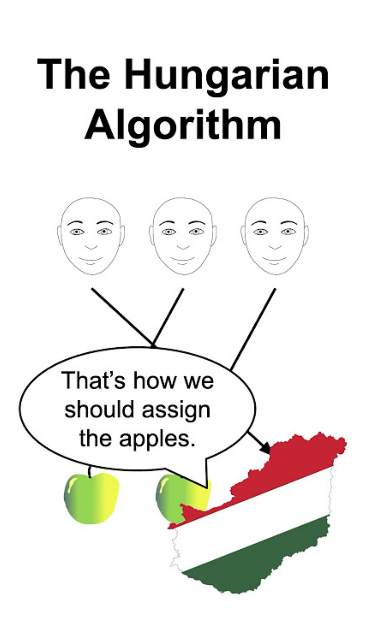

In [27]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('oardefault.jpg')
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

**BONUS**

Możemy przekształcić nasz początkowy problem na problem maksymalnego przepływu. W tym miejscu pozostawię jedynie implementację za pomocą zewnętrznych bibliotek.

In [14]:
import networkx as nx

def solve_assignment_networkx(cost_matrix):
    n = len(cost_matrix)
    G = nx.DiGraph()

    source = "S"
    sink = "T"

    # Add edges from source to workers
    for i in range(n):
        G.add_edge(source, f"w{i}", capacity=1, weight=0)

    # Add edges from jobs to sink
    for j in range(n):
        G.add_edge(f"j{j}", sink, capacity=1, weight=0)

    # Add edges between workers and jobs with cost
    for i in range(n):
        for j in range(n):
            cost = cost_matrix[i][j]
            G.add_edge(f"w{i}", f"j{j}", capacity=1, weight=cost)

    # Compute min-cost max-flow
    flow_dict = nx.max_flow_min_cost(G, source, sink)
    cost = nx.cost_of_flow(G, flow_dict)

    # Extract matching
    matching = []
    for i in range(n):
        for j in range(n):
            if flow_dict[f"w{i}"].get(f"j{j}", 0) == 1:
                matching.append((i,j))
    return matching, cost


In [24]:
solve_assignment_networkx(przykład)

([(0, 2), (1, 1), (2, 0)], 45)

In [16]:
import numpy as np
from tqdm.notebook import tqdm
N = 1000
results = []
ex = []
for i in tqdm(range(N)):
    M = np.random.randint(1,15)
    #size = np.random.randint(10, 25)
    test__ = np.random.randint(low=0, high=100, size=(M,M))
    results.append((solve_assignment_networkx(test__)[1] )== (hungarian_algorithm_standard(test__)[1]))
    if not results[-1]:
        ex.append(test__)

print(f"Poprawność algorytmu: {sum(results)/N}")

  0%|          | 0/1000 [00:00<?, ?it/s]

Poprawność algorytmu: 1.0
